# Описание проекта

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Есть  данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

<a id='tap_table_of_contents'></a>
## Оглавление
<dl>
    <dt><a href='#plan'>План</a></dt><br/>
    <dt><a href='#opis_dann'>Описание данных</a></dt><br/>
    <dt><a href='#data_preparation'>1. Подготовка данных</a></dt>
    <ol>
        <a href='#open'>1.1. Откройте файлы и изучите их</a><br/>
        <a href='#test_efficiency'>1.2. Проверка эффективности обогащения</a><br/>
        <a href='#feature_analysis'>1.3. Анализ признаков, недоступных в тестовой выборке</a><br/>
        <a href='#data_preprocessing'>1.4. Предобработка данных</a><br/><br/>
    </ol>
    <dt><a href='#data_analysis'>2. Анализ данных</a></dt><br/>
    <ol>
        <a href='#viewing_concentration_changes'>2.1. Посмотр изменений концентрации металлов</a><br/>
        <a href='#distribution_comparison'>2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках</a><br/>
        <a href='#total_concentration'>2.3. Суммарная концентрация всех веществ на разных стадиях</a><br/><br/>
    </ol>
    <dt><a href='#model'>3. Модель</a></dt><br/>
    <ol>
        <a href='#sMAPE'>3.1. Функция для вычисления итоговой sMAPE</a><br/>
        <a href='#choose_the_best_model'>3.2. Выбрать лучшую модель и проверить её на тестовой выборке</a>
    </ol>
    
</dl>

<a id='plan'></a>
##  План
    1. Подготовьте данные
      1.1. Откроем файлы и изучим их.
      Путь к файлам:
      /datasets/gold_recovery_train.csv.
      /datasets/gold_recovery_test.csv.
      /datasets/gold_recovery_full.csv.
      1.2. Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака                 rougher.output.recovery. Найдем MAE между расчётами и значением признака. Опишем выводы.
      1.3. Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
      1.4. Проведем предобработку данных.
    2. Проанализируем данные
      2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишем выводы.
      2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются       друг от друга, оценка модели будет неправильной.
      2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.             Заметим аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок?             Опишем выводы и удалите аномалии.
    3. Построим модель
      3.1. Напишем функцию для вычисления итоговой sMAPE.
      3.2. Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой               выборке. Опишем выводы.

<dt><a href='#tap_table_of_contents'>Оглавление</a></dt>

<a id='opis_dann'></a>
## Описание данных
    Данные находятся в трёх файлах:
      gold_recovery_train.csv — обучающая выборка;
      gold_recovery_test.csv — тестовая выборка;
      gold_recovery_full.csv — исходные данные Скачать датасет.
    Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

<a id='data_preparation'></a>
# 1. Подготовка данных

<a id='open'></a>
## 1.1. Откройте файлы и изучите их

<dt><a href='#tap_table_of_contents'>Оглавление</a></dt>

In [333]:
# импортируем необходимые библитотеки
import pandas as pd
import time
import math 
import warnings
import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [334]:
# откроем файлы и запишем их
data_initial = pd.read_csv('/datasets/gold_recovery_full.csv')
data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test.csv')

# выведем на экран
display(data_initial.head())
display(data_train.head())
display(data_test.head())

# алгоритм для поиска столбцов содержащих 'final.output', 'rougher.output'
data_train_columns = data_train.columns
data_train_columns_output = []
for k in data_train_columns:
    if 'final.output' in k:
        data_train_columns_output.append(k)
for k in data_train_columns:
    if 'rougher.output' in k:
        data_train_columns_output.append(k)
print(data_train_columns_output)

# уберем пропуски в этих столбцах
data_train.dropna(subset = data_train_columns_output, inplace = True)
display(data_train.loc[:,data_train_columns_output])

# посмотрим на результат
print(data_train['rougher.output.recovery'].isna().sum())
print(data_train['rougher.output.concentrate_au'].isna().sum())
print(data_train['rougher.input.feed_au'].isna().sum())
print(data_train['rougher.output.tail_au'].isna().sum())

# запонлним интерполяцией оставшиеся пропуски
data_initial.fillna(method = 'ffill', inplace = True)
data_train.fillna(method = 'ffill', inplace = True)
data_test.fillna(method = 'ffill', inplace = True)

# посмотрим на результат
data_initial.info()
data_train.info()
data_test.info()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au']


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,11.615865,7.278807,28.067063,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,11.695753,7.216833,27.454037,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,11.915047,7.175616,27.341277,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,12.411054,7.240205,27.041023,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,11.124896,10.984003,30.068876,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633
16856,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,11.425983,10.888213,29.783972,18.441436,87.724007,4.177943,0.650557,16.960649,0.771582
16857,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,8.523497,8.955135,22.786467,15.111231,88.890579,4.050010,0.636095,18.323080,0.685059
16858,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,11.658799,10.655377,29.052742,17.834772,89.858126,3.902494,0.625609,19.423740,0.567130


0
0
0
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22716 non-null float64
final.output.concentrate_pb                           22716 non-null float64
final.output.concentrate_sol                          22716 non-null float64
final.output.concentrate_au                           22716 non-null float64
final.output.recovery                                 22716 non-null float64
final.output.tail_ag                                  22716 non-null float64
final.output.tail_pb                                  22716 non-null float64
final.output.tail_sol                                 22716 non-null float64
final.output.tail_au                                  22716 non-null float64
primary_cleaner.input.sulfate                         22716 non-null float64
primary_cleaner.input.depressant     

## Вывод
3 датасета. Основной поделен на обучающий и тестовый в отношении (3:1). В обучающем столько же столбцов сколько в основном `87`, тестовый содержит меньше `53`. Убрали пропуски в выходных характеристиках сырья.

<a id='test_efficiency'></a>
## 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

<dt><a href='#tap_table_of_contents'>Оглавление</a></dt>

In [335]:
# выделим почитанный признак
rougher_output_recovery_train = data_train['rougher.output.recovery']

# выделим пизнаки для подсчета признака
c = data_train['rougher.output.concentrate_au']
f = data_train['rougher.input.feed_au']
t = data_train['rougher.output.tail_au'] 

# посчитаем сами и сравним с условием с  помощью MAE
rougher_output_recovery_manually = c * (f - t)/(f * (c - t)) * 100
mae_rougher = mean_absolute_error(rougher_output_recovery_manually, rougher_output_recovery_train)
print('MAE между данными и своим подсчетом:', mae_rougher)

MAE между данными и своим подсчетом: 9.483936877516321e-15


## Вывод
Мы получили характеристику MAE практически равную нулю, что означает, что конверсия посчитана верно и данные подготолены верно (для этой характеристики).

<a id='feature_analysis'></a>
## 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

<dt><a href='#tap_table_of_contents'>Оглавление</a></dt>

In [336]:
# выделим названия столбцов
data_initial_colimns = data_initial.columns
data_test_columns = data_test.columns

# отбросим те что есть в тестовой выборке
inaccessible_signs = []
for i in data_initial_colimns:
    if i not in data_test_columns:
        inaccessible_signs.append(i)
inaccessible_signs = pd.Series(inaccessible_signs)
print(inaccessible_signs)

#удалим их оставив толко final.output.recovery и rougher.output.recovery для дальнейшей работы
columns_nodrop = ['final.output.recovery', 'rougher.output.recovery']
data_nodrop = data_train[columns_nodrop]
data_train.drop(inaccessible_signs, axis = 1,inplace = True)
data_train[columns_nodrop] = data_nodrop
# посмотрим на измененния
print(data_train.shape)

0                           final.output.concentrate_ag
1                           final.output.concentrate_pb
2                          final.output.concentrate_sol
3                           final.output.concentrate_au
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_pb
7                                 final.output.tail_sol
8                                  final.output.tail_au
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_pb
11               primary_cleaner.output.concentrate_sol
12                primary_cleaner.output.concentrate_au
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_pb
15                      primary_cleaner.output.tail_sol
16                       primary_cleaner.output.tail_au
17        rougher.calculation.sulfate_to_au_conc

## Вывод
В тестовых данных отсутствуют все столбцы с типом `output`. А также `calculation` на стадии флотации. Поэтому придется их предсказать.

<a id='data_preprocessing'></a>
## 1.4. Проведите предобработку данных.

## Вывод
Данные были предобработаны на прошлых этапах, для таблицы `train` произведено заполнение `Nan` с помощью метода `ffill`. По предаврительной оценке(и после прочтения пукта `2.3`), мы понимаем что дальнейшая предобработка данных не нужна.  

<a id='data_analysis'></a>
# 2. Анализ данных

<a id='viewing_concentration_changes'></a>
## 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

<dt><a href='#tap_table_of_contents'>Оглавление</a></dt>

final.output.concentrate_au              39.891718
primary_cleaner.output.concentrate_au    29.119967
rougher.output.concentrate_au            17.831509
dtype: float64
final.output.concentrate_ag               4.768013
primary_cleaner.output.concentrate_ag     7.666972
rougher.output.concentrate_ag            10.845609
dtype: float64
final.output.concentrate_pb              9.071366
primary_cleaner.output.concentrate_pb    8.809217
rougher.output.concentrate_pb            6.886869
dtype: float64


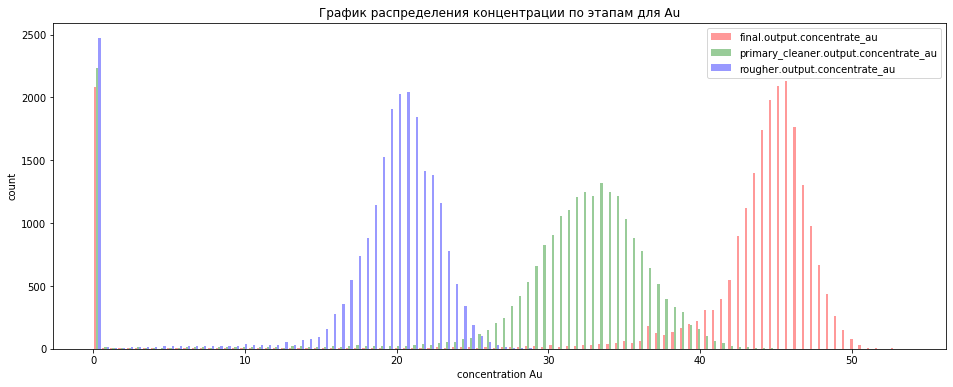

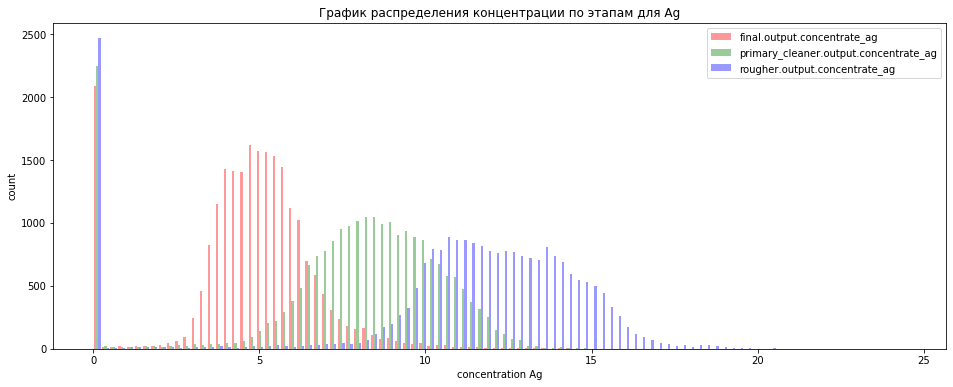

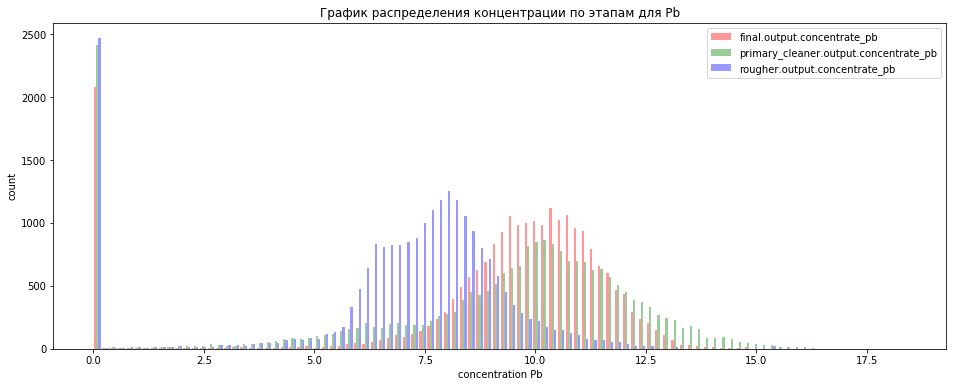

In [337]:
# выделим все столбцы с концентрацией Au, Ag, Pb
dict_columns = {'au':'concentrate_au','ag':'concentrate_ag','pb':'concentrate_pb'}
concentration_changes_columns = {'au': [], 'ag' : [], 'pb' : []}

# функцию для и упакем столбцы в словарь где ключами будут (Au, Ag, Pb)
def concentrate_changes_columns(df):
    for k in ['au', 'ag', 'pb']:
        column = df[f'{k}']
        for i in data_initial.columns:
            if column in i:
                concentration_changes_columns[f'{k}'].append(i)
                
# применим функцию
concentrate_changes_columns(dict_columns)

# запищем отдельно столбцы для таблиц по каждому металлу
column_list_au = concentration_changes_columns['au']
column_list_ag = concentration_changes_columns['ag']
column_list_pb = concentration_changes_columns['pb']

# составим таблицы для Au, Ag, Pb
data_au = data_initial[column_list_au]
data_ag = data_initial[column_list_ag]
data_pb = data_initial[column_list_pb]

# посмотрим на изменение средней концентрации
print(data_au.mean())
print(data_ag.mean())
print(data_pb.mean())

# функция для создания графиков
def schedule(El, data):
    plt.subplots(figsize=(16, 6))
    plt.title('График распределения концентрации по этапам для ' + El)
    el = sns.distplot(data, kde=False, color = ['red','green','blue'], bins = 100,  label = 
                  ['final.output.concentrate_' + str.lower(El),'primary_cleaner.output.concentrate_' + str.lower(El),
                   'rougher.output.concentrate_'+ str.lower(El)])
    el.legend()
    plt.xlabel('concentration '+ El)
    plt.ylabel("count")
    plt.show()

# выведем графики    
schedule('Au', data_au)
schedule('Ag', data_ag)
schedule('Pb', data_pb)

## Вывод
Мы видем что концентрация золота стабильно растет на протяжении всего обогащения (в среднем почти на 50% за каждый этап). В то же время концентрация серебра стремительно падает (в 2 раза меньше чем после флотации). Концентрация свинца также стабильно растет как и у золота но процент очень мал(на выходе в среднем 10%)

<a id='distribution_comparison'></a>
## 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

<dt><a href='#tap_table_of_contents'>Оглавление</a></dt>

In [338]:
# игнорим всякие предупреждения) 
warnings.filterwarnings('ignore')

,train_primary_cleaner.input.feed_size,test_primary_cleaner.input.feed_size
0,7.25,8.080000
1,7.25,8.080000
2,7.25,7.786667
3,7.25,7.640000
4,7.25,7.530000


,train_rougher.input.feed_size,test_rougher.input.feed_size
0,55.486599,62.710452
1,57.278666,61.961163
2,57.510649,66.903807
3,57.792734,59.865919
4,56.047189,63.315324


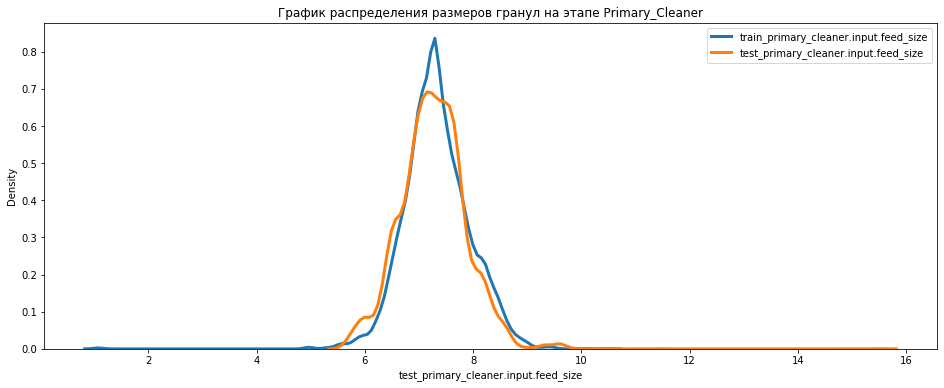

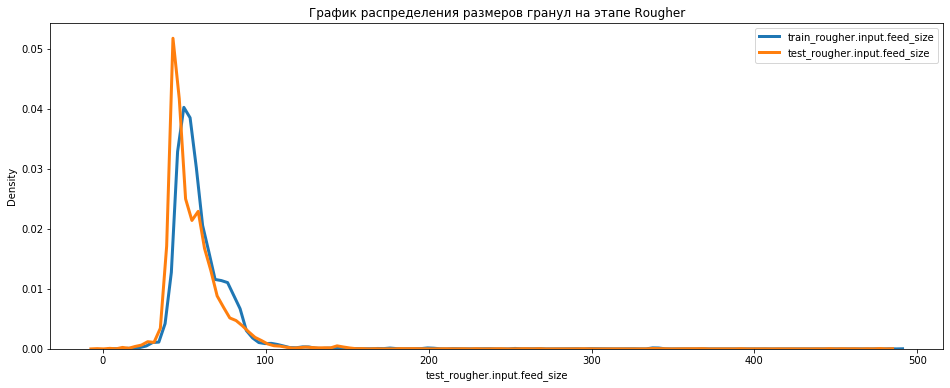

primary_cleaner.input.feed_size     7.330242
rougher.input.feed_size            60.307603
dtype: float64
primary_cleaner.input.feed_size     7.264651
rougher.input.feed_size            55.898866
dtype: float64
отношение дисперсий  0.043320093944148506
отношение дисперсий  -0.017109086977676963


In [339]:
# выделим необходимые столбцы
data_feed_size = []
for k in data_train:
    if 'feed_size' in k:
        data_feed_size.append(k)
        
# объединим таблицы отдельно 'primary_cleaner' и 'rougher'
data_primary_cleaner_feed_size = pd.concat([data_train[data_feed_size[0]],data_test[data_feed_size[0]]],axis=1)
data_rougher_feed_size = pd.concat([data_train[data_feed_size[1]],data_test[data_feed_size[1]]],axis=1)

# переименуем столбцы 
data_primary_cleaner_feed_size.columns = ['train_primary_cleaner.input.feed_size','test_primary_cleaner.input.feed_size']
data_rougher_feed_size.columns = ['train_rougher.input.feed_size','test_rougher.input.feed_size']

# выведем
display(data_primary_cleaner_feed_size.head())
display(data_rougher_feed_size.head())

# функция для постороения графика рампределения
def schedule_01(El, data):
    plt.subplots(figsize=(16, 6))    
    plt.title('График распределения размеров гранул на этапе ' + El)
    plt.xlabel(str.lower(El) + '.feed_size')
    plt.ylabel("Density")
    for i in data.columns:
        el = sns.distplot(data[i], hist = False, kde = True,kde_kws = {'linewidth': 3}, label = i)
    plt.legend()
    plt.show()

# применим
schedule_01('Primary_Cleaner', data_primary_cleaner_feed_size)
schedule_01('Rougher', data_rougher_feed_size)

# выделим таблицы отдельно для выборок 
data_train_feed_size = data_train[data_feed_size]
data_test_feed_size = data_test[data_feed_size]

# рапечатаем
print(data_train_feed_size.mean())
print(data_test_feed_size.mean())

# функция для отношения дисперсий
def dispersion(row):
    train = data_train_feed_size[row + '.input.feed_size']
    test = data_test_feed_size[row + '.input.feed_size']
    print('отношение дисперсий ',(train.var() - test.var()) / test.var())

# посмотрим отношение test к train    
dispersion('rougher')
dispersion('primary_cleaner')

## Вывод
Распределение выборок различается не сильно, дисперсии не превышают 5%. Визуализация(Графики) подтверждают это, они довольно симметричны, но график `test` меньше из-за количества строк в таблице. 

<a id='total_concentration'></a>
## 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

<dt><a href='#tap_table_of_contents'>Оглавление</a></dt>

0        66.424950
1        67.012710
2        66.103793
3        65.752751
4        65.908382
           ...    
22711    70.781325
22712    70.539603
22713    55.376330
22714    69.201689
22715    69.544003
Name: all_summa_rougher, Length: 22716, dtype: float64

,all_summa_input,all_summa_rougher,all_summa_final
0,51.680034,66.424950,63.644396
1,50.659114,67.012710,63.957723
2,50.609929,66.103793,64.311180
3,51.061546,65.752751,63.573449
4,47.859163,65.908382,64.004667
...,...,...,...
22711,53.415050,70.781325,68.098589
22712,53.696482,70.539603,68.274362
22713,54.589604,55.376330,68.226068
22714,54.027355,69.201689,68.200449


{'input': ['rougher.input.feed_ag',
  'rougher.input.feed_pb',
  'rougher.input.feed_sol',
  'rougher.input.feed_au'],
 'rougher': ['rougher.output.concentrate_ag',
  'rougher.output.concentrate_pb',
  'rougher.output.concentrate_sol',
  'rougher.output.concentrate_au'],
 'final': ['final.output.concentrate_ag',
  'final.output.concentrate_pb',
  'final.output.concentrate_sol',
  'final.output.concentrate_au']}

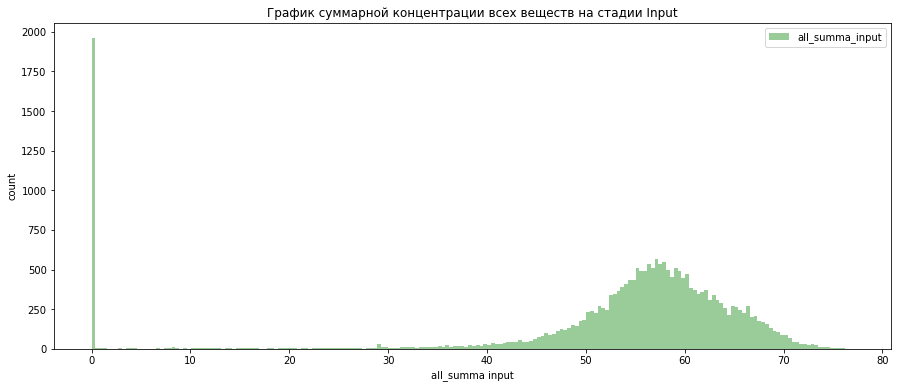

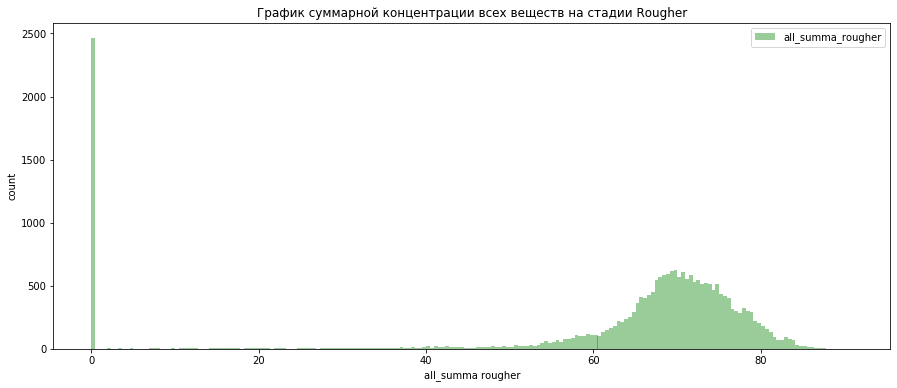

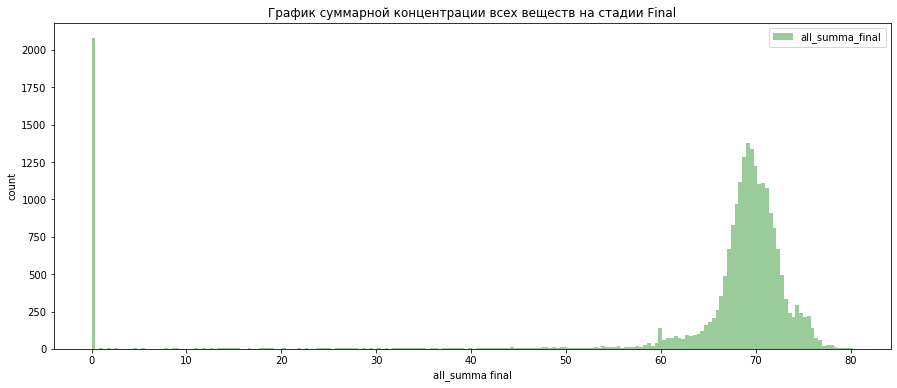

Новая длина обучающей выборки: 13804
Новая длина тестовой выборки: 5485


In [340]:
# выделим словари для столбцов
dict_all_concentration = {'input' : 'rougher.input.feed', 
                          'rougher' : 'rougher.output.concentrate', 'final' : 'final.output.concentrate'}
dict_all_concentration_columns = {'input' : [], 'rougher' : [], 'final' : []}

# с помощью функции заполним 2 словарь нужными нам столбцами
def total_concentration(df):
    for k in ['input', 'rougher', 'final']:
        column = df[f'{k}']
        for i in data_initial.columns:
            if column in i:
                dict_all_concentration_columns[f'{k}'].append(i)

# применим функцию 
total_concentration(dict_all_concentration)

# перезапишем отдельно под каждый этап
column_list_input = dict_all_concentration_columns['input']
column_list_rougher = dict_all_concentration_columns['rougher']
column_list_final = dict_all_concentration_columns['final']

# составим таблицы для train и будем смотреть по нему (т.к. в test из нужных есть только данные о сырье)
data_input_01 = data_initial.loc[:,column_list_input]

# дропнем ненужные столцы в input
data_input_01.drop(['rougher.input.feed_rate','rougher.input.feed_size'], axis = 1, inplace =  True)
data_rougher = data_initial.loc[:,column_list_rougher] 
data_final = data_initial.loc[:,column_list_final]

# запишем в отдельный столбец сумму всех концентраций(по этапам)
data_input = data_input_01.sum(axis=1)
data_rougher.loc[:,'all_summa_rougher'] = data_rougher.sum(axis=1)
data_final.loc[:,'all_summa_final'] = data_final.sum(axis=1)

# выведем rougher для примера
display(data_rougher['all_summa_rougher'])

# заполним все в одну таблицу 
data_all_concentration = pd.DataFrame(columns = ['all_summa_input','all_summa_rougher','all_summa_final'])
data_all_concentration.loc[:,'all_summa_input'] = data_input
data_all_concentration.loc[:,'all_summa_rougher'] = data_rougher.loc[:,'all_summa_rougher'] 
data_all_concentration.loc[:,'all_summa_final'] = data_final.loc[:,'all_summa_final']

# посмотрим 
display(data_all_concentration)

# изменим список c ключом input для словаря 
dict_all_concentration_columns['input'] = data_input_01.columns.tolist()

# посмотрим 
display(dict_all_concentration_columns)

# функция для создания графиков
def schedule_02(El, data):
    plt.subplots(figsize=(15, 6))
    plt.title('График суммарной концентрации всех веществ на стадии ' + El)
    el = sns.distplot(data, kde=False, color = 'green', bins = 200,  label = 'all_summa_' + str.lower(El))
    el.legend()
    plt.xlabel('all_summa '+ str.lower(El))
    plt.ylabel("count")
    plt.show()

# применим функцию для построяния графиков 
schedule_02('Input', data_all_concentration.loc[:,'all_summa_input'])
schedule_02('Rougher',data_all_concentration.loc[:,'all_summa_rougher'])
schedule_02('Final', data_all_concentration.loc[:,'all_summa_final']) 

# зададим функцию для удаления выбросов(в данном случае значения с сумарной конецнтрацией равной 0)
def total_concentration(df, df_columns):
    for k in ['input', 'rougher', 'final']:
        column = dict_all_concentration_columns[f'{k}']
        for i in df_columns:
            if i in column:
                all_summ = k + '_all_summa'
                df[all_summ] = df[column].sum(axis = 1)
                df = df[df[all_summ] > 1]
                df.drop(all_summ, axis = 1, inplace = True)
    return df

# применим к выборкам
data_train = total_concentration(data_train, data_train.columns)
data_test = total_concentration(data_test, data_test.columns)

data_train.reset_index(inplace = True)
data_test.reset_index(inplace = True)

# посмотрим на изменение длины датасетов
print('Новая длина обучающей выборки:',len(data_train))
print('Новая длина тестовой выборки:',len(data_test))

## Вывод
Замено, что суммарная концентрация растет.  Есть выбросы с нулевой концентрацией которые стоит удалить в обеих выборках для частоты эксперемента. После удаления стало в среднем на `400` строк меньше. что для выборки `train` - 3%, для `test` - 7% данных.

<a id='model'></a>
# 3. Модель

<a id='sMAPE'></a>
## 3.1. Напишите функцию для вычисления итоговой sMAPE.

<dt><a href='#tap_table_of_contents'>Оглавление</a></dt>

In [341]:
df2 = pd.DataFrame(np.array([[-1.54,-5.5345,-2.543,3.535], [1.23,7.563,2.364,3.536], [1.36,9.536,2.36,3.36], [1.364,8.536,2.64,3.34]]),
                   columns=['a', 'b', 'c', 'd'])
def smape(target, predicted):
    smaped = (2 * np.absolute(target - predicted)/((np.absolute(target) + np.absolute(predicted)))) * 100
    return smaped

# функция подсчета sMAPE
def general_smape(target, predicted):
    predicted = pd.DataFrame(predicted, columns = target.columns,index = target.index)
    smape_rougher = smape(target[target.columns[0]], predicted[predicted.columns[0]])
    smape_final = smape(target[target.columns[1]], predicted[predicted.columns[1]])
    smape_all = .25 * smape_rougher + .75 * smape_final
    smape_all_mean = smape_all.mean()
    return smape_all_mean

## Вывод
Функция задана и работает осталось поcтроить модель и проверить ее качество на реальных данных

<a id='choose_the_best_model'></a>
## 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

<dt><a href='#tap_table_of_contents'>Оглавление</a></dt>

In [342]:
# так как индексы сбрасывали то сделаем даты новыми индексами
data_test.set_index('date', inplace = True)
data_initial.set_index('date', inplace = True)

# запишем фитчи  для тестовой выборки 
features_test = data_test
features_test.drop('index',axis = 1,  inplace = True)
# добавим недостоющие столбцы test таблице
data_test = data_test.merge(data_initial, how = 'inner', on = 'date')

In [343]:
%%time
# присвоим столбцы
features = data_train.drop(['rougher.output.recovery','final.output.recovery','date','index'], axis = 1)
target_train = pd.DataFrame(columns = ['rougher.output.recovery','final.output.recovery'])
target_train['rougher.output.recovery'] = data_train['rougher.output.recovery']
target_train['final.output.recovery'] = data_train['final.output.recovery']

# для решающего леса
state = 12345
clf = RandomForestRegressor(random_state = state)
forest_parametrs = { 'n_estimators': range (10, 31, 10),
              'max_depth': range (1,5, 2),
              'min_samples_leaf': range (1,3),
              'min_samples_split': range (2,10,2) }

scorer = make_scorer(general_smape)
grid_clf = GridSearchCV(clf, forest_parametrs, cv = 3, scoring = scorer)
grid_clf.fit(features, target_train)
print('The parameters combination that would give best sMAPE is : ')
print(grid_clf.best_params_)
print('The sMAPE accuracy achieved after parameter tuning via grid search is : ', grid_clf.best_score_)

10.242667282211626
12.072487350548453
12.446969477576276
10.259782018194276
12.068508982010588
12.446189061034321
10.263158973517974
12.082847839276878
12.432398575621766
10.242667282211626
12.072487350548453
12.446969477576276
10.259782018194276
12.068508982010588
12.446189061034321
10.263158973517974
12.082847839276878
12.432398575621766
10.242667282211626
12.072487350548453
12.446969477576276
10.259782018194276
12.068508982010588
12.446189061034321
10.263158973517974
12.082847839276878
12.432398575621766
10.242667282211626
12.072487350548453
12.446969477576276
10.259782018194276
12.068508982010588
12.446189061034321
10.263158973517974
12.082847839276878
12.432398575621766
10.242667282211626
12.072487350548453
12.446969477576276
10.259782018194276
12.068508982010588
12.446189061034321
10.263158973517974
12.082847839276878
12.432398575621766
10.242667282211626
12.072487350548453
12.446969477576276
10.259782018194276
12.068508982010588
12.446189061034321
10.263158973517974
12.082847839

In [344]:
%%time
# для линейной регрессии
lir = LinearRegression()
regression_parametrs = {'fit_intercept' : [True,False]}

scorer = make_scorer(general_smape)
grid_lir = GridSearchCV(lir, regression_parametrs, cv = 5, scoring = scorer)
grid_lir.fit(features, target_train)
print('The parameters combination that would give best sMAPE is : ')
print(grid_lir.best_params_)
print('The sMAPE accuracy achieved after parameter tuning via grid search is : ', grid_lir.best_score_)

12.007808665432835
9.25925499523716
12.632048681971668
11.32589704279764
12.78532910692936
10.751319137441733
9.83604917754128
13.095941455416824
11.410076033245884
13.143520920398531
The parameters combination that would give best sMAPE is : 
{'fit_intercept': False}
The sMAPE accuracy achieved after parameter tuning via grid search is :  11.64727296031337
CPU times: user 2.23 s, sys: 1.6 s, total: 3.83 s
Wall time: 3.81 s


## Вывод
Возьмем лес, недостаток скорости он компенисрует точностью показаний. 

In [345]:
# теперь можно создать тестовые таргеты
target_test = pd.DataFrame(columns = ['rougher.output.recovery','final.output.recovery'])
target_test['rougher.output.recovery'] = data_test['rougher.output.recovery']
target_test['final.output.recovery'] = data_test['final.output.recovery']

# предскажем на тестовой выборке
model = RandomForestRegressor(**grid_clf.best_params_, random_state=12345)
model.fit(features, target_train)
predicted_test = model.predict(features_test)


# посчитаем sMAPE 
result_1 = general_smape(target_test,predicted_test)
print('Cимметричное среднее абсолютное процентное отклонение модели на тестовой  выборке:', result_1)

# тест на вменяемость 
du_reg = DummyRegressor(strategy = 'median')
du_reg.fit(features, target_train)

# педскажем
predicted_test_du = du_reg.predict(features_test)

# сравним с нашей моделью 
result_2 = general_smape(target_test,predicted_test_du)
print('Cимметричное среднее абсолютное процентное отклонение для теста на адекватность:', result_2)

10.405231596018174
Cимметричное среднее абсолютное процентное отклонение модели на тестовой  выборке: 10.405231596018174
10.552506498439085
Cимметричное среднее абсолютное процентное отклонение для теста на адекватность: 10.552506498439085


## Вывод
В ходе работы мы обработали данные, проанализировали их и сделали модель с хоошим показателем sMAPE. Лучшей моделью оказался решающий лес с подобранными нами параметрами.Мы получили довольно неплохие показатели этой модели на тестовой выборке. Тест на адекватность модель прошла, проверили с помощью DummyRegressor с параметром `strategy = 'median'`